In [1]:
import math
import numpy as np
from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    
    rule = w1*(abs(xt-c1/r1))**3+(1-w1)*(abs(xt-c2/r2))**3
    at = min(max(rule, 0.01), 0.1)
    return at
    

def lake_model(b=0.42, q=2.0, mean=0.02, stdev=0.001, alpha=0.4,     
                 delta=0.98, c1=0.25, c2=0.25, r1=0.5, r2=0.5,
                 w1=0.5, nsamples=100, steps=100, seed=None):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    X = np.zeros((steps,))
    decisions = np.zeros((steps,))

    X[0] = 0.0

    natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size = steps)

    for t in range(1,steps):
        decisions[t-1] = get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/float(steps)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.diff(decisions) > -0.01)/float(steps-1)
    return X, utility, inertia, reliability

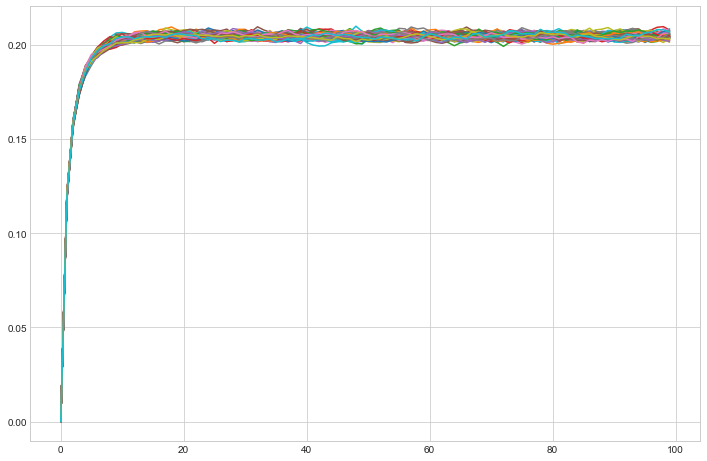

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)

for _ in range(100):
    X, utility, inertia, reliability = lake_model()
    ax.plot(X)

In [3]:
%load_ext Cython

In [4]:
%%cython --annotate

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

cdef inline float float_max(float a, float b): return a if a >= b else b
cdef inline float float_min(float a, float b): return a if a <= b else b

ctypedef np.float_t DTYPE_t

@cython.cdivision(True)
cpdef float cython_get_antropogenic_release(float xt, float c1, float c2, float r1, 
                             float r2, float w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    cdef float rule, at, var1, var2, test
    
    var1 = (xt-c1)/r1
    var1 = abs(var1)
    var2 = (xt-c2)/r2
    var2 = abs(var2)
    
    rule = w1*(var1**3)+(1-w1)*(var2**3)
    at = float_min(float_max(rule, 0.01), 0.1)
    return at
    
@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, float stdev=0.001, 
               float alpha=0.4, float delta=0.98, float c1=0.25,
               float c2=0.25, float r1=0.5, float r2=0.5, float w1=0.5, 
               int nsamples=100, int steps=100):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
#     np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        decisions[t-1] = cython_get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.diff(decisions) > -0.01)/(steps-1)
    return X, utility, inertia, reliability

In [14]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

#instantiate the model
class ReplicatorModel(Replicator, BaseModel):
    pass
lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [46]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(policies=500)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 500 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


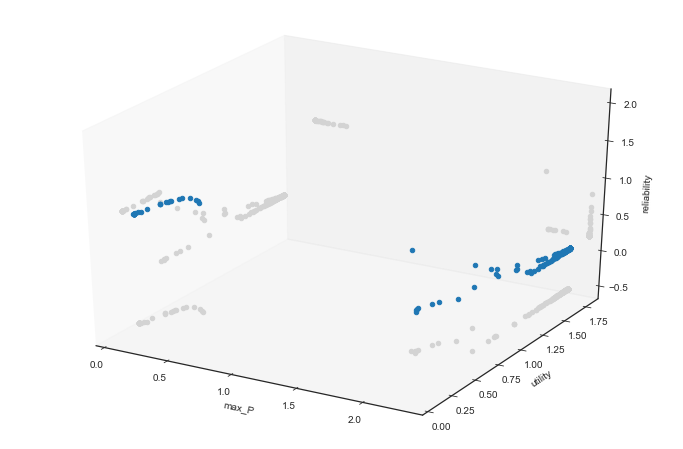

In [52]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_style('white')

experiments, outcomes = results

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.grid(b=False)

x = outcomes['max_P']
y = outcomes['utility']
z = outcomes['reliability']

ax.scatter(x, y, z, depthshade=False)


ax.scatter(x, z, c='lightgrey', zdir='y', zs=2, depthshade=False)
ax.scatter(y, z, c='lightgrey', zdir='x', zs=0, depthshade=False)
ax.scatter(x, y, c='lightgrey', zdir='z', zs=-0.5, depthshade=False)

ax.set_xlabel("max_P")
ax.set_ylabel("utility")
ax.set_zlabel("reliability")
plt.show()